In [1]:
import sys
if True:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/burgers/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/burgers/")
else:
    root = './'
import numpy as np
import torch
from matplotlib import pylab as plt
if torch.cuda.device_count()>0:
    device = torch.device('cuda')
    print("Connected to a GPU")
else:
    print("Using the CPU")
    device = torch.device('cpu')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Using the CPU


In [ ]:
import importlib
import util
importlib.reload(util)
from util import *

In [ ]:
loss = torch.nn.MSELoss()

In [ ]:
dataname = "heat"
data = np.load(root+f"data/{dataname}.npz")
dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
Ntraj,Nt,Nx = dataset.shape

In [ ]:
def train_it(dataset, model,
             OPTIM=torch.optim.Adam, learning_rate = 1e-1, 
             batch_size=20, Npast=1, Nfuture=1):
    optimizer = OPTIM(model.parameters(), lr=learning_rate)
    Nepoch = 100
    Ntotal = dataset.shape[0]*(dataset.shape[1]-(Npast+1)-Nfuture)
    Nbatch = batch_size #Ntotal//10
    Niter = Nepoch * Ntotal//Nbatch
    Nprint = (Niter)//10
    Nsave = 100
    losses = np.zeros((Niter//Nsave,2))
    
    for e in range(Niter):
        xx,yy = get_batch(Nbatch, dataset, Nfuture=Nfuture)
        # We iterate multiple times:
        y_pred = model(xx)+xx
        L = loss(y_pred,yy[:,(0,),:])
        for i in range(1,Nfuture):
            h = y_pred
            y_pred = model(h)+h
            L += loss(y_pred, yy[:,(i,),:])
        # Optimize:
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        # Make stats:
        if e%Nprint == Nprint-1:
            print(e,L.item())
        if e%Nsave == Nsave-1:
            xxt,yyt = test_batch(dataset)
            yt_pred = model(xxt)+xxt
            test_err = loss(yyt,yt_pred)
            losses[e//Nsave,0] = L.item()
            losses[e//Nsave,1] = test_err.item()
    return losses

# Verify that the algorithm works on the linear stencil:

In [50]:
name = "PureStencil"
model_cls = models[name]
stash = {}
for nf in [1,2,3,4,5]:
    model = model_cls(Nx).to(device)
    results = train_it(dataset,model,Nfuture=nf)
    stash[nf] = {
        'model':model,
        'results':results,
    }

484 2.0951714759576134e-05
969 1.9291503122076392e-05
1454 3.0026039894437417e-06
1939 9.739243978401646e-06
2424 2.92091453957255e-06
2909 3.225270120310597e-05
3394 1.4191676882546744e-06
3879 1.3845868807038642e-06
4364 3.592437133193016e-05
4849 2.982141609209066e-07
479 0.00010814311099238694
959 6.351762567646801e-05
1439 0.00032680248841643333
1919 1.9833238184219226e-05
2399 1.0859424946829677e-05
2879 4.4100133322899637e-07
3359 1.59761867735142e-07
3839 2.650871522291709e-09
4319 1.6676577896390654e-09
4799 1.1186244153194025e-09
474 0.0005157077684998512
949 0.0001976558705791831
1424 0.0006048213690519333
1899 0.005392054095864296
2374 9.973968190024607e-06
2849 0.0002669990644790232
3324 0.00014406524132937193
3799 1.0668170489225304e-06
4274 0.0004352401592768729
4749 9.976049852866709e-08
469 0.0009377485839650035
939 0.0009904750622808933
1409 0.00012113997945562005
1879 0.0005983176524750888
2349 2.368328205193393e-05
2819 0.00026227557100355625
3289 1.369014512420108e

In [52]:
for N,S in stash.items():
    print(N," : ",list(S['model'].parameters())[0].detach())

1  :  tensor([[[ 0.3888, -0.7796,  0.3887]]])
2  :  tensor([[[ 0.3989, -0.7979,  0.3989]]])
3  :  tensor([[[ 0.3968, -0.7932,  0.3968]]])
4  :  tensor([[[ 0.3928, -0.7862,  0.3927]]])
5  :  tensor([[[ 0.3941, -0.7870,  0.3941]]])


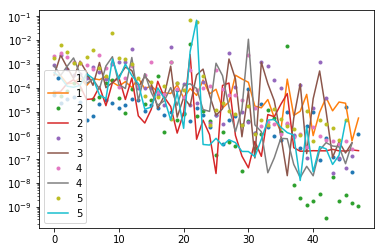

In [60]:
for N,S in stash.items():
    plt.semilogy(S['results'][:,0],'.',label=N)
    plt.semilogy(S['results'][:,1],'-',label=N)
plt.legend()
plt.show()

# Now try the more complicated networks:

In [ ]:
models = {#"PureStencil":PureStencil,
         "PureLinear":PureLinear,
          "DeepStencil":DeepStencil,
          "LeakyDeepStencil":LeakyDeepStencil,
          #"LeakyFCMLP":LeakyFCMLP,
          #"FCMLP":FCMLP
         }
stash = {}

In [74]:
for N,model_cls in models.items():
    for nf in [2,3,4,5]:
        key = f"{N}_{nf}"
        try:
            model =  stash[key]['model']
            results =stash[key]['loss']
            print("Resuming training of ",key)
        except KeyError:
            model = model_cls(Nx).to(device)
            results = np.empty((0,3))
            print("Training new ",key)
        model = model_cls(Nx).to(device)
        results = train_it(dataset,model,Nfuture=nf, learning_rate = 1.0e-3)
        stash[key] = {
            'model':model,
            'results':results,
        }

Training  PureLinear  @  2
Training new  PureLinear_2
479 1.1518456233261531e-07
959 1.6830929894240398e-07
1439 9.427290024177637e-07
1919 3.901829472852114e-07
2399 1.2653617886826396e-06
2879 1.3671615306520835e-06
3359 1.0028431461250875e-05
3839 1.117458168664598e-06
4319 7.031474069663091e-06
4799 1.4872236988594523e-06
Training  PureLinear  @  3
Training new  PureLinear_3
474 1.7311958799837157e-05
949 1.4961976830818458e-06
1424 2.3517363842984196e-06
1899 1.3762908110948047e-06
2374 1.0933525118161924e-05
2849 8.044028618314769e-06
3324 2.3793204491084907e-06
3799 7.861810445319861e-06
4274 5.786078418168472e-06
4749 1.346184581052512e-05
Training  PureLinear  @  4
Training new  PureLinear_4
469 0.00024248860427178442
939 1.5715864719823003e-05
1409 1.130936561821727e-05
1879 3.7346053431974724e-06
2349 9.617804607842118e-06
2819 9.736313586472534e-06
3289 2.8770455173798837e-05
3759 0.00026628325576893985
4229 2.658618541317992e-05
4699 3.556097362888977e-05
Training  PureLin

In [ ]:
with open(root+f"/multistep_{dataname}.pkl","wb") as f:
        torch.save(stash,f)

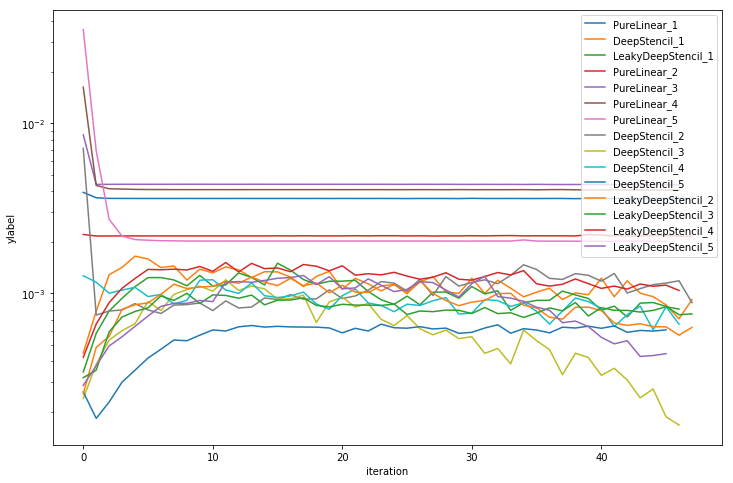

In [86]:
plt.figure(figsize=(12,8))
for N,S in stash.items():
    #plt.semilogy(S['results'][:,0],'--',label=N)
    plt.semilogy(S['results'][:,1],'-',label=N)
plt.xlabel('iteration')
plt.ylabel('ylabel')
plt.legend()
plt.savefig(root+'paper/multistep.png',dpi=300)
plt.show()
